In [ ]:
import os
import glob
from IPython.display import Image as IPImage
import pandas as pd             
import numpy as np              
import matplotlib.pyplot as plt 
import seaborn as sns           
from PIL import Image           
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.layers import Flatten, Dense, Activation, Dropout
from keras import models, optimizers
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import DenseNet121
from keras.applications.densenet import DenseNet121, preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
train_data = './breast_dataset/Dataset_BUSI_with_GT'

pd.DataFrame(
    os.listdir(train_data),
    columns=['File Name']
)

,File Name
0,malignant
1,normal
2,benign


In [ ]:
train_files = [i for i in glob.glob(train_data + "/*/*")]

np.random.shuffle(train_files)

labels = [os.path.dirname(i).split("/")[-1] for i in train_files]

data = zip(train_files, labels)

training_data = pd.DataFrame(data, columns=["Path", "Label"])

training_data

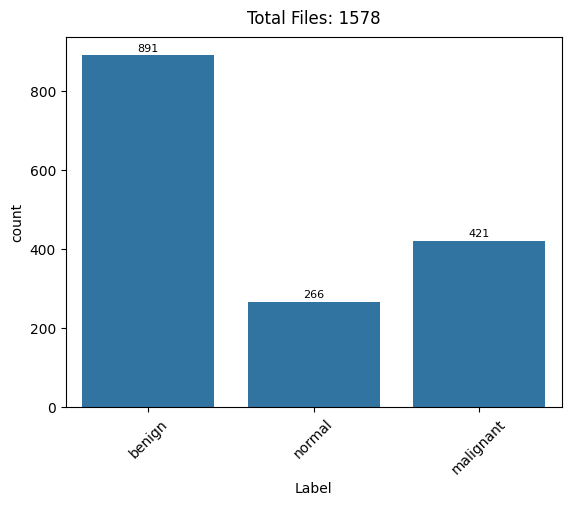

In [ ]:
ax = sns.countplot(x=training_data["Label"])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)

plt.xticks(rotation=45)

plt.title(f'Total Files: {len(training_data)}', pad=10)

plt.show()

In [10]:
data_paths = []
labels = []

main_dirs = os.listdir(train_data)
for folder_name in main_dirs:
    folder_path = os.path.join(train_data, folder_name)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data_paths.append(file_path)
        labels.append(folder_name)

In [ ]:
batch_size = 32

image_size = (150, 150)

num_channels = 3

image_shape = (image_size[0], image_size[1], num_channels)

data_dirs = pd.Series(data_paths, name='Path')

classes = pd.Series(labels, name='Label')

def preprocess_image(img):
    return img

train_df, val_test_df = train_test_split(
    training_data,
    train_size=0.8,
    shuffle=True,
    random_state=123
)

val_df, test_df = train_test_split(
    val_test_df,
    train_size=0.5,
    shuffle=False,
    random_state=123
)

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=1.0/255
)

train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 1262 validated image filenames belonging to 3 classes.
Found 158 validated image filenames belonging to 3 classes.


In [ ]:
class_indices = train_generator.class_indices

class_indices.keys()

dict_keys(['benign', 'malignant', 'normal'])

In [ ]:
labels = []

for key in class_indices.keys():
    labels.append(key)  

total_labels = len(labels)

print("Labels: ", labels)
print("\nTotal no. of unique labels:", total_labels)

Labels:  ['benign', 'malignant', 'normal']

Total no. of unique labels: 3


(570, 771)
(465, 555)
(574, 772, 3)
(470, 562, 3)
(473, 426, 3)
(473, 556, 3)
(475, 567, 3)
(483, 552, 3)


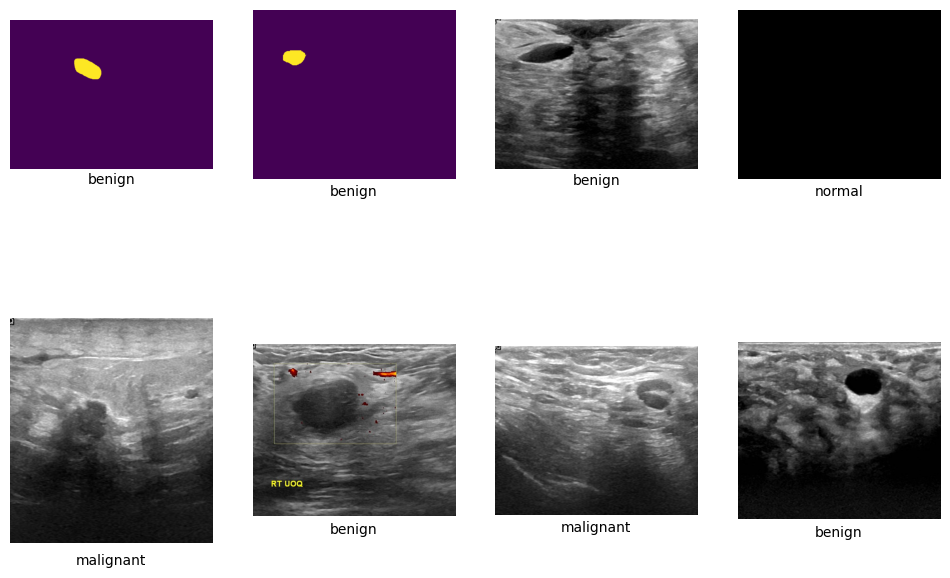

In [ ]:
no_of_rows = 2
no_of_columns = 4

fig, axes = plt.subplots(no_of_rows, no_of_columns, figsize=(12, 8))

for i in range(no_of_rows):
    for j in range(no_of_columns):
        index = i * no_of_columns + j

        if index < len(training_data):

            im = Image.open(training_data.iloc[index]['Path'])

            img = np.array(im)

            print(img.shape)

            axes[i, j].imshow(img)

            axes[i, j].axis('off')

            label = training_data.iloc[index]['Label']
            axes[i, j].text(0.5, -0.1, label, ha='center', transform=axes[i, j].transAxes)

plt.show()

In [ ]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      16,778,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,456,195 (97.11 MB)

 Trainable params: 18,418,691 (70.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  
    metrics=['accuracy']              
)

In [ ]:
history = model.fit(
    train_generator,                                   
    epochs=15,                                         
    validation_data=valid_generator,                   
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 995ms/step - accuracy: 0.5574 - loss: 2.7799 - val_accuracy: 0.7722 - val_loss: 0.4528
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.8102 - loss: 0.4746 - val_accuracy: 0.8608 - val_loss: 0.3456
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.8564 - loss: 0.3632 - val_accuracy: 0.8481 - val_loss: 0.3470
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.8783 - loss: 0.2990 - val_accuracy: 0.8797 - val_loss: 0.3449
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.8844 - loss: 0.2889 - val_accuracy: 0.8608 - val_loss: 0.3238
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.8754 - loss: 0.2790 - val_accuracy: 0.8544 - val_loss: 0.3340
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.9268 - loss: 0.2010 - val_accuracy: 0.8671 - val_loss: 0.3678
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9304 - loss: 0.1876 - val_accuracy:

In [19]:
model.save("breas.h5")

5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step


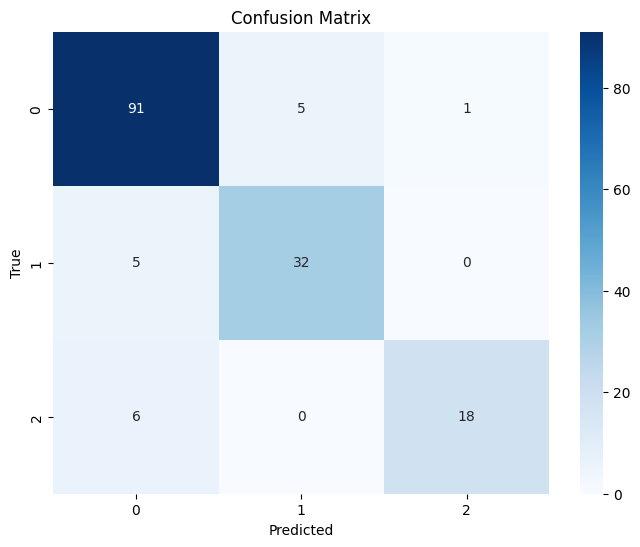

In [ ]:
predictions = model.predict(valid_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = valid_generator.classes

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [ ]:
class_report = classification_report(true_labels, predicted_labels)
print(class_report)

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        97
           1       0.86      0.86      0.86        37
           2       0.95      0.75      0.84        24

    accuracy                           0.89       158
   macro avg       0.90      0.85      0.87       158
weighted avg       0.89      0.89      0.89       158



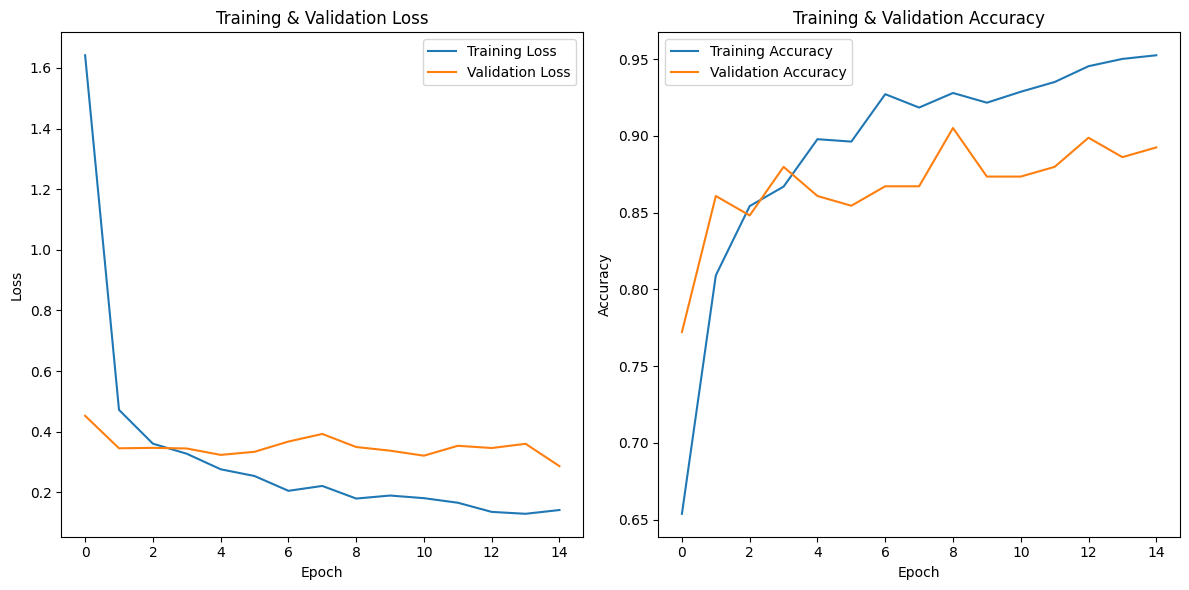

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()